# Preparation

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import cv2

import google.colab for using drive file if it is necessary 

In [ ]:
from google.colab import drive


drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Determine some necessary path

In [ ]:

groundtruth_path = ""    # groundtruth location     "  #### -->  \trodo-v01\trodo-v01\ground truth\groundtruth.json"
images_path = ""         # Images location      " #### -->  \trodo-v01\trodo-v01\images"
annotations_path = ""    # pascal voc 1.1 annotations location      "  #### -->  \trodo-v01\trodo-v01\pascal voc 1.1\Annotations"

Normalization image data

In [ ]:
import json
import pandas as pd
import os

json_path = open(groundtruth_path)
json_data = json.load(json_path)
label_data = pd.json_normalize(json_data["odometers"])
label_data_droped_mileage = label_data.drop("mileage", axis = 1)

Defining some lists

In [ ]:
labels = []
features = []
odometers_borders = []

Function check whether the variable is an integer or a string

In [ ]:
def int_or_str(x):

  try:

    x = int(x)

  except ValueError:

    pass

  return x

 Function read xml file

In [ ]:
import xml.etree.ElementTree as ET


def read_xml_file(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()


    filename = root.find('filename').text

    for boxes in root.iter('object'):

        if int_or_str(boxes.find("name").text) == "odometer":

          ymin, xmin, ymax, xmax, object_name = None, None, None, None, None

          ymin = float(boxes.find("bndbox/ymin").text)
          xmin = float(boxes.find("bndbox/xmin").text)
          ymax = float(boxes.find("bndbox/ymax").text)
          xmax = float(boxes.find("bndbox/xmax").text)
          odometers_borders.append([(filename),(int(ymin), int(ymax), int(xmin), int(xmax))])


reading xml file

In [ ]:
for xml_file_name in os.listdir(annotations_path):

  if ".xml" in xml_file_name:
    xml_file_path = f"{annotations_path}/{xml_file_name}"
    read_xml_file(xml_file_path)

Odometer is cropped from the images. Odometer images are resized and converted to grey.

In [ ]:
for odometer in odometers_borders:
  image_name = odometer[0]
  image_path = f"{images_path}/{image_name}"
  image = cv2.imread(image_path)
  image = image[odometer[1][0] : odometer[1][1] , odometer[1][2] : odometer[1][3]]
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image, (100, 50), interpolation = cv2.INTER_AREA)

  labels.append(label_data_droped_mileage.loc[label_data_droped_mileage['image'] == image_name, 'odometer_type'].iloc[0])
  features.append(image)

In [ ]:
len(labels)

2389

Display of images after processing

(-0.5, 99.5, 49.5, -0.5)

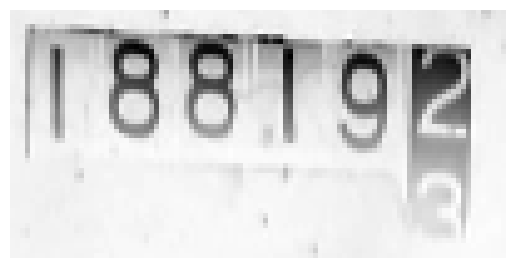

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.imshow(features[808], cmap=mpl.cm.binary)
plt.axis("off")

(-0.5, 99.5, 49.5, -0.5)

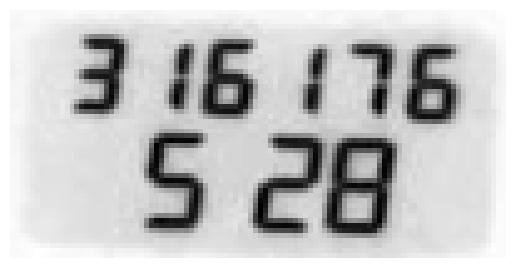

In [ ]:
plt.imshow(features[1150], cmap=mpl.cm.binary)
plt.axis("off")

Labels are converted from string to binary.  "digital" = 1 , "analog" = 0

In [ ]:
i = 0
labels_binary = []

for label in labels:

  if label == "digital":

    labels_binary.append(1)

  elif label == "analog":

    labels_binary.append(0)


Lists are converted to numpy array

In [ ]:
labels_binary = np.asarray(labels_binary)
features = np.asarray(features)

Splitting test and train set

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels_binary, test_size=0.19, shuffle=True, stratify=labels)

x_train and x_test arrays are converted from 3D to 2D

In [ ]:
samp, x, y = x_train.shape
x_train = x_train.reshape((samp,x*y))

In [ ]:
samp, x, y = x_test.shape
x_test = x_test.reshape((samp,x*y))

# LogisticRegression 

Some hyperparameters are determined to used RandomizedSearch

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

randomizedsearch_parameters_LogisticRegression = [

    {"solver": ["lbfgs"],
     "penalty": ["l2"],
     "C": [0.88, 0.95, 1, 1.1, 1.12, 1.06],
     "tol": [0.0001, 0.0012, 0.00002, 0.00005],
     "multi_class": ["auto"],
     "max_iter": [4000]},

]

Model is trained different parameters 15 time and for every trained model performs cross-validation 5 time.

In [ ]:
LOGREG = LogisticRegression()

LOGREG_randomizedsearch = RandomizedSearchCV(LOGREG, randomizedsearch_parameters_LogisticRegression, cv = 5, n_iter = 15, verbose = 1, scoring = "roc_auc")

LOGREG_randomizedsearch.fit(x_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=15,
                   param_distributions=[{'C': [0.88, 0.95, 1, 1.1, 1.12, 1.06],
                                         'max_iter': [4000],
                                         'multi_class': ['auto'],
                                         'penalty': ['l2'], 'solver': ['lbfgs'],
                                         'tol': [0.0001, 0.0012, 2e-05,
                                                 5e-05]}],
                   scoring='roc_auc', verbose=1)

Best parameters

In [ ]:
LOGREG_randomizedsearch.best_params_

{'tol': 2e-05,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'multi_class': 'auto',
 'max_iter': 4000,
 'C': 0.88}

In [ ]:
LOGREG_randomizedsearch.best_estimator_

LogisticRegression(C=0.88, max_iter=4000, tol=2e-05)

In [ ]:
LOGREG_MODEL = LOGREG_randomizedsearch.best_estimator_

Prediction of model on the train and test sets 

In [ ]:
y_train_LOGREG_prediction = LOGREG_MODEL.predict(x_train)

In [ ]:
y_test_LOGREG_prediction = LOGREG_MODEL.predict(x_test)

# Performance on train set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

In [ ]:
accuracy_score(y_train, y_train_LOGREG_prediction)

1.0

In [ ]:
precision_score(y_train, y_train_LOGREG_prediction)

1.0

In [ ]:
recall_score(y_train, y_train_LOGREG_prediction)

1.0

In [ ]:
f1_score(y_train, y_train_LOGREG_prediction)

1.0

In [ ]:
confusion_matrix(y_train, y_train_LOGREG_prediction)

array([[ 695,    0],
       [   0, 1240]])

# Performance on test set

In [ ]:
accuracy_score(y_test, y_test_LOGREG_prediction)

0.9801762114537445

In [ ]:
precision_score(y_test, y_test_LOGREG_prediction)

0.9795918367346939

In [ ]:
recall_score(y_test, y_test_LOGREG_prediction)

0.9896907216494846

In [ ]:
f1_score(y_test, y_test_LOGREG_prediction)

0.9846153846153847

In [ ]:
confusion_matrix(y_test, y_test_LOGREG_prediction)

array([[157,   6],
       [  3, 288]])

# SGDClassifier

Some hyperparameters are determined to used RandomizedSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier


randomizedsearch_parameters_SGDClassifier = [
    {"loss": ["log_loss","hinge"],
     "penalty": ["elasticnet","l2","l1"],
     "learning_rate": ["optimal","adaptive"],
     "max_iter": [2000],
     "eta0": [0.01, 0.08, 0.2],
     "epsilon": [0.1, 0.3, 0.4, 1, 2, 8, 16]}
]

Model is trained different parameters 100 time and for every trained model performs cross-validation 4 time.

In [ ]:
SGDC = SGDClassifier()

SGDC_randomizedsearch = RandomizedSearchCV(SGDC, randomizedsearch_parameters_SGDClassifier, cv= 4, n_iter=100, verbose = 1, scoring = "roc_auc", n_jobs = 2)

SGDC_randomizedsearch.fit(x_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=SGDClassifier(), n_iter=100, n_jobs=2,
                   param_distributions=[{'epsilon': [0.1, 0.3, 0.4, 1, 2, 8,
                                                     16],
                                         'eta0': [0.01, 0.08, 0.2],
                                         'learning_rate': ['optimal',
                                                           'adaptive'],
                                         'loss': ['log_loss', 'hinge'],
                                         'max_iter': [2000],
                                         'penalty': ['elasticnet', 'l2',
                                                     'l1']}],
                   scoring='roc_auc', verbose=1)

Best parameters

In [ ]:
SGDC_randomizedsearch.best_params_

{'penalty': 'elasticnet',
 'max_iter': 2000,
 'loss': 'log_loss',
 'learning_rate': 'optimal',
 'eta0': 0.01,
 'epsilon': 0.4}

In [ ]:
SGDC_MODEL = SGDC_randomizedsearch.best_estimator_

Prediction of model on the train and test sets 

In [ ]:
y_train_SGDC_prediction = SGDC_MODEL.predict(x_train)

In [ ]:
y_test_SGDC_prediction = SGDC_MODEL.predict(x_test)

# Performance on train set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

In [ ]:
accuracy_score(y_train, y_train_SGDC_prediction)

0.9964249233912156

In [ ]:
precision_score(y_train, y_train_SGDC_prediction)

0.9952380952380953

In [ ]:
recall_score(y_train, y_train_SGDC_prediction)

0.999203187250996

In [ ]:
f1_score(y_train, y_train_SGDC_prediction)

0.9972166998011928

In [ ]:
confusion_matrix(y_train, y_train_SGDC_prediction)

array([[ 697,    6],
       [   1, 1254]])

# Performance on test set

In [ ]:
accuracy_score(y_test, y_test_SGDC_prediction)

0.9698375870069605

In [ ]:
precision_score(y_test, y_test_SGDC_prediction)

0.9713261648745519

In [ ]:
recall_score(y_test, y_test_SGDC_prediction)

0.9818840579710145

In [ ]:
f1_score(y_test, y_test_SGDC_prediction)

0.9765765765765766

In [ ]:
confusion_matrix(y_test, y_test_SGDC_prediction)

array([[147,   8],
       [  5, 271]])

# KNeighborsClassifier

Some hyperparameters are determined to used GridSearch

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

gridsearch_parameters_KNN = [
    {"n_neighbors": [1, 2, 3],
     "weights": ["uniform", "distance"],
     "algorithm": ["auto"],
     "leaf_size": [43, 46, 48, 50, 52, 54, 57, 60, 62],
     "p": [1, 2]}
]

Model is trained different parameters 108 time and for every trained model performs cross-validation 4 time.

In [ ]:
KNN = KNeighborsClassifier()
gridsearch_KNN = GridSearchCV(KNN, gridsearch_parameters_KNN, cv = 4, verbose = 1, scoring = "accuracy")
gridsearch_KNN.fit(x_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto'],
                          'leaf_size': [43, 46, 48, 50, 52, 54, 57, 60, 62],
                          'n_neighbors': [1, 2, 3], 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=1)

Best parameters

In [ ]:
gridsearch_KNN.best_params_

{'algorithm': 'auto',
 'leaf_size': 43,
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

In [ ]:
gridsearch_KNN.best_estimator_

KNeighborsClassifier(leaf_size=43, n_neighbors=2, p=1)

In [ ]:
KNN_MODEL = gridsearch_KNN.best_estimator_

Prediction of model on the train and test sets 

In [ ]:
y_train_KNN_prediction = KNN_MODEL.predict(x_train)

In [ ]:
y_test_KNN_prediction = KNN_MODEL.predict(x_test)

# Performance on train set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

accuracy_score(y_train, y_train_KNN_prediction)

0.9948320413436692

In [ ]:
precision_score(y_train, y_train_KNN_prediction)

1.0

In [ ]:
recall_score(y_train, y_train_KNN_prediction)

0.9919354838709677

In [ ]:
f1_score(y_train, y_train_KNN_prediction)

0.9959514170040485

In [ ]:
confusion_matrix(y_train, y_train_KNN_prediction)

array([[ 695,    0],
       [  10, 1230]])

# Performance on test set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

accuracy_score(y_test, y_test_KNN_prediction)

0.933920704845815

In [ ]:
precision_score(y_test, y_test_KNN_prediction)

0.9169329073482428

In [ ]:
recall_score(y_test, y_test_KNN_prediction)

0.9862542955326461

In [ ]:
f1_score(y_test, y_test_KNN_prediction)

0.9503311258278146

In [ ]:
confusion_matrix(y_test, y_test_KNN_prediction)

array([[137,  26],
       [  4, 287]])

# DecisionTreeClassifier

Some hyperparameters are determined to used GridSearch

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


gridsearch_parameters_DecisionTreeClassifier = [{
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter":  ["best", "random"],
    "max_features": ["sqrt", "log2", 3],
    "max_depth": [3000],
    "random_state": [1, 2, 3, 6, 12, 15]
}]

Model is trained different parameters 108 time and for every trained model performs cross-validation 6 time.

In [ ]:
DTC = DecisionTreeClassifier()

gridsearch_DTC = GridSearchCV(DTC, gridsearch_parameters_DecisionTreeClassifier, cv=6, verbose = 1)
gridsearch_DTC.fit(x_train, y_train)

Fitting 6 folds for each of 108 candidates, totalling 648 fits


GridSearchCV(cv=6, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [3000],
                          'max_features': ['sqrt', 'log2', 3],
                          'random_state': [1, 2, 3, 6, 12, 15],
                          'splitter': ['best', 'random']}],
             verbose=1)

Best parameters

In [ ]:
gridsearch_DTC.best_params_

{'criterion': 'entropy',
 'max_depth': 3000,
 'max_features': 'sqrt',
 'random_state': 1,
 'splitter': 'best'}

In [ ]:
DTC_MODEL = gridsearch_DTC.best_estimator_

Prediction of model on the train and test sets 

In [ ]:
y_train_DTC_prediction = DTC_MODEL.predict(x_train)

In [ ]:
y_test_DTC_prediction = DTC_MODEL.predict(x_test)

# Performance on train set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

accuracy_score(y_train, y_train_DTC_prediction)

1.0

In [ ]:
precision_score(y_train, y_train_DTC_prediction)

1.0

In [ ]:
recall_score(y_train, y_train_DTC_prediction)

1.0

In [ ]:
f1_score(y_train, y_train_DTC_prediction)

1.0

In [ ]:
confusion_matrix(y_train, y_train_DTC_prediction)

array([[ 695,    0],
       [   0, 1240]])

# Performance on test set

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

accuracy_score(y_test, y_test_DTC_prediction)

0.8700440528634361

In [ ]:
precision_score(y_test, y_test_DTC_prediction)

0.8741935483870967

In [ ]:
recall_score(y_test, y_test_DTC_prediction)

0.9312714776632303

In [ ]:
f1_score(y_test, y_test_DTC_prediction)

0.9018302828618967

In [ ]:
confusion_matrix(y_test, y_test_DTC_prediction)

array([[124,  39],
       [ 20, 271]])